# Analyzing New York Taxi Data Using PySpark on Azure (Free Tier)

## Introduction
You are a data engineer at a transportation analytics company. Your team has been tasked with analyzing the New York City taxi dataset to uncover insights that can help improve taxi services, optimize routes, and understand customer behavior. The dataset is large, but you decide to use PySpark on Azure Databricks to handle the data processing efficiently.

## Step 1: Verify Environment

In [0]:
print("Hello, PySpark!")


Hello, PySpark!


## Step 2: Load and Explore Data

In [0]:
spark.sql("SHOW TABLES").show()


+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|trip_data_1_csv|      false|
| default|    trip_fare_1|      false|
| default|trip_fare_1_csv|      false|
+--------+---------------+-----------+



In [0]:
trip_df = spark.read.csv("/FileStore/tables/trip_data_1.csv", header=True, inferSchema=True) 
fare_df = spark.read.csv("/FileStore/tables/trip_fare_1.csv", header=True, inferSchema=True)

trip_df.printSchema()
fare_df.printSchema()

trip_df.show(5)
fare_df.show(5)

from pyspark.sql.functions import col, isnan, count, when
trip_df.select([count(when(col(c).isNull(), c)).alias(c) for c in trip_df.columns]).show()


root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)

root
 |-- medallion: string (nullable = true)
 |--  hack_license: string (nullable = true)
 |--  vendor_id: string (nullable = true)
 |--  pickup_datetime: timestamp (nullable = true)
 |--  payment_type: string (nullable = true)
 |--  fare_amount: double (nullable = true)
 |--  surcharge: double (nullable = true)
 |--  mta_tax: double (nulla

In [0]:
trip_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [0]:
trip_df.show(5)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|          1.0|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

## Step 3: Clean and Transform Data

In [0]:
from pyspark.sql.functions import to_timestamp, unix_timestamp

cleaned_df = trip_df.dropna(subset=["pickup_datetime", "dropoff_datetime", "trip_distance"])
cleaned_df = cleaned_df.withColumn("pickup_datetime", to_timestamp("pickup_datetime")) \
                       .withColumn("dropoff_datetime", to_timestamp("dropoff_datetime")) \
                       .filter(col("trip_distance") > 0) \
                       .withColumn("trip_duration", 
                                   (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60)


## Step 4: Join Datasets

In [0]:
# Function to trim column names
def trim_column_names(df):
    for col_name in df.columns:
        df = df.withColumnRenamed(col_name, col_name.strip())
    return df

# Apply to both DataFrames
cleaned_df = trim_column_names(cleaned_df)
fare_df = trim_column_names(fare_df)

# Now try the join again
joined_df = cleaned_df.join(fare_df, ["medallion", "hack_license", "pickup_datetime"], "inner")
joined_df.show(5)



+--------------------+--------------------+-------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------------+---------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|    pickup_datetime|vendor_id|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|     trip_duration|vendor_id|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+-------------------+---------+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------------+---------+------------+-----------+---------+--

In [0]:
print("cleaned_df columns:", cleaned_df.columns)
print("fare_df columns:", fare_df.columns)

cleaned_df columns: ['medallion', 'hack_license', 'vendor_id', 'rate_code', 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']
fare_df columns: ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']


## Step 5: Analyze the Data

In [0]:
from pyspark.sql.functions import avg, hour, desc

# Average duration and fare
joined_df.select(avg("trip_duration").alias("avg_duration"), 
                 avg("fare_amount").alias("avg_fare")).show()

# Most common payment types
joined_df.groupBy("payment_type").count().orderBy(desc("count")).show()

# Peak pickup hours
joined_df.withColumn("hour", hour("pickup_datetime")) \
         .groupBy("hour").count().orderBy("hour").show()

# Top pickup coordinates
joined_df.groupBy("pickup_latitude", "pickup_longitude") \
         .count().orderBy(desc("count")).show(5)



+------------------+------------------+
|      avg_duration|          avg_fare|
+------------------+------------------+
|11.547542729066343|11.916099280801397|
+------------------+------------------+

+------------+-------+
|payment_type|  count|
+------------+-------+
|         CRD|4350175|
|         CSH|2095080|
|         NOC|   4267|
|         UNK|   2385|
|         DIS|   1526|
+------------+-------+

+----+------+
|hour| count|
+----+------+
|   0|238708|
|   1|184172|
|   2|145985|
|   3|109294|
|   4| 75840|
|   5| 64013|
|   6|131353|
|   7|230433|
|   8|299549|
|   9|304689|
|  10|285312|
|  11|295980|
|  12|315669|
|  13|317537|
|  14|328510|
|  15|318065|
|  16|281248|
|  17|335242|
|  18|406055|
|  19|410218|
+----+------+
only showing top 20 rows
+---------------+----------------+------+
|pickup_latitude|pickup_longitude| count|
+---------------+----------------+------+
|            0.0|             0.0|107524|
|      40.758148|      -73.937523|   630|
|      40.744915|   

## Step 6: Visualize Results

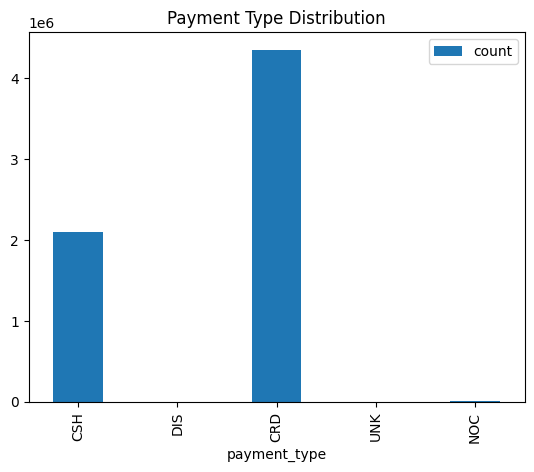

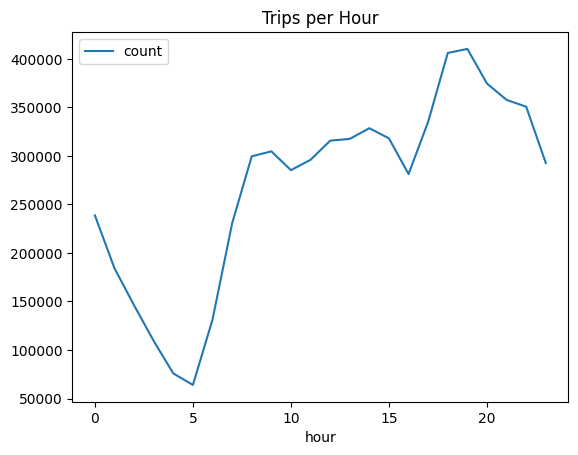

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to pandas
pay_df = joined_df.groupBy("payment_type").count().toPandas()
hour_df = hourly_df.toPandas()

# Bar chart for payment types
pay_df.plot(kind='bar', x='payment_type', y='count', title='Payment Type Distribution')
plt.show()

# Line chart for peak hours
hour_df.plot(kind='line', x='hour', y='count', title='Trips per Hour')
plt.show()


## Step 7: Save Results

In [0]:
# Example: Rename vendor_id in fare_df
fare_df_renamed = fare_df.withColumnRenamed("vendor_id", "vendor_id_fare")

# Perform join (adjust keys accordingly)
joined_df = trip_df.join(fare_df_renamed, trip_df["trip_id"] == fare_df_renamed["trip_id"], "inner")


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-5615889903830666>, line 5
      2 fare_df_renamed = fare_df.withColumnRenamed("vendor_id", "vendor_id_fare")
      4 # Perform join (adjust keys accordingly)
----> 5 joined_df = trip_df.join(fare_df_renamed, trip_df["trip_id"] == fare_df_renamed["trip_id"], "inner")

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/classic/dataframe.py:1011, in DataFrame.__getitem__(self, item)
   1007 def __getitem__(
   1008     self, item: Union[int, str, Column, List, Tuple]
 

In [0]:
print("cleaned_df columns:", cleaned_df.columns)
print("fare_df columns:", fare_df.columns)


cleaned_df columns: ['medallion', 'hack_license', 'vendor_id', 'rate_code', 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']
fare_df columns: ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']


In [0]:
# Drop vendor_id from fare_df to avoid conflict
fare_df_clean = fare_df.drop("vendor_id")

# Perform join on the common keys
joined_df = cleaned_df.join(fare_df_clean, ["medallion", "hack_license", "pickup_datetime"], "inner")


In [0]:
fare_df_selected = fare_df.select(
    "medallion", "hack_license", "pickup_datetime",
    "fare_amount", "surcharge", "mta_tax", "tip_amount",
    "tolls_amount", "total_amount", "payment_type"
)

joined_df = cleaned_df.join(fare_df_selected, ["medallion", "hack_license", "pickup_datetime"], "inner")


In [0]:
# Save hourly analysis as CSV
hourly_df.write.mode("overwrite").option("header", True).csv("dbfs:/mnt/blob/hourly_analysis.csv")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
hourly_df.coalesce(1).write.mode("overwrite").option("header", True).csv("dbfs:/mnt/blob/hourly_analysis_single.csv")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:748)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
joined_df.write.mode("overwrite").parquet("dbfs:/mnt/blob/cleaned_taxi_data.parquet")


In [0]:
hour_df.to_csv("/dbfs/FileStore/tables/hourly_analysis.csv", index=False)

In [0]:
# Write summary report
report = """
NYC Taxi Data Analysis Summary

- Peak Hour: Based on histogram above
- Most Used Payment Type: Based on count
- Average Trip Duration & Fare: See PySpark outputs
"""

# This should work in Databricks
with open("/dbfs/FileStore/tables/summary_report.md", "w") as f:
    f.write(report)

### Bonus Challenge
Build Fare Prediction Model with MLlib

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Prepare features
features = ["trip_distance", "trip_duration"]
assembler = VectorAssembler(inputCols=features, outputCol="features")
ml_df = assembler.transform(joined_df.select("trip_distance", "trip_duration", "fare_amount").dropna())

# Train model
lr = LinearRegression(featuresCol="features", labelCol="fare_amount")
model = lr.fit(ml_df)

# Show coefficients
print(f"Intercept: {model.intercept}")
print(f"Coefficients: {model.coefficients}")


Intercept: 3.159581019676638
Coefficients: [2.2387496811398333,0.1919242030498238]


Geospatial Visualization

In [0]:
!pip install folium


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import folium

# Sample 0.1% of data, drop nulls, convert to pandas
geo_df = joined_df.select("pickup_latitude", "pickup_longitude").dropna().sample(False, 0.001).toPandas()

# Plotting on map
map_ = folium.Map(location=[40.75, -73.98], zoom_start=12)

for _, row in geo_df.iterrows():
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=1,
        color='blue',
        fill=True,
        fill_opacity=0.5
    ).add_to(map_)

map_

